In [3]:
import websocket
import threading
import requests
import json
import datetime
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from dydx3 import Client

### Data Prepocessing

In [2]:
CLIENT = Client(host='https://api.dydx.exchange')
COIN_LIST_dydx = list(CLIENT.public.get_markets().data['markets'].keys())

path = "F:/Strategy/crypto/DYDX_funding/historical_data/bybit" 
files = os.listdir(path)
COIN_LIST_bybit = []
for file in files:
    COIN_LIST_bybit.append(file.split('_')[3].split('.')[0])

# find the intersection of coins, but bybit is 'BTCUSDT' and dydx is 'BTC-USD'
COIN_LIST_TOTAL = [coin.split('-')[0] for coin in COIN_LIST_dydx if coin.split('-')[0]+'USDT' in COIN_LIST_bybit]
len(COIN_LIST_TOTAL)  

NameError: name 'Client' is not defined

In [1]:
def get_data(coin):

    df_dydx = pd.read_csv(f"F:/Strategy/crypto/DYDX_funding/historical_data/dydx/{coin}-USD_funding.csv").drop(columns=['Unnamed: 0', 'market', 'price'])
    df_dydx['effectiveAt'] = pd.to_datetime(df_dydx['effectiveAt'], utc=True)
    df_dydx = df_dydx.rename(columns={'effectiveAt': 'timestamp', 'price': 'dydx_price', 'rate': 'dydx_rate'})

    df_dydx_price = pd.read_csv(f"F:/Strategy/crypto/DYDX_funding/historical_data/dydx price/{coin}-USD_price.csv").drop(columns=['market', 'startingOpenInterest', 'baseTokenVolume', 'usdVolume', 'high', 'low', 'trades', 'resolution', 'Unnamed: 0'])
    df_dydx_price['timestamp'] = pd.to_datetime(df_dydx_price['timestamp'], utc=True)
    df_dydx_price = df_dydx_price.rename(columns={'open': 'dydx_open', 'close': 'dydx_close', 'volume': 'dydx_volume', 'quoteTokenVolume': 'dydx_quoteTokenVolume'})

    df_bybit = pd.read_excel(f"F:/Strategy/crypto/DYDX_funding/historical_data/bybit/funding_rate_history_{coin}USDT.xlsx").drop(columns=['Symbol'])
    df_bybit['Time(UTC)'] = pd.to_datetime(df_bybit['Time(UTC)'], utc=True)
    df_bybit = df_bybit.rename(columns={'Time(UTC)': 'timestamp', 'Funding Rate': 'bybit_rate'})

    df_bybit_price = pd.read_csv(f"F:/Strategy/crypto/DYDX_funding/historical_data/bybit price/{coin}USDT_price.csv").drop(columns=['Unnamed: 0', 'volume', 'turnover', 'high', 'low'])
    df_bybit_price['timestamp'] = pd.to_datetime(df_bybit_price['timestamp'], utc=True)
    df_bybit_price = df_bybit_price.rename(columns={'open': 'bybit_open', 'close': 'bybit_close'})

    #merge the 3 on timestamp
    df = pd.merge(df_dydx, df_bybit, on='timestamp', how='outer')
    df = pd.merge(df, df_bybit_price, on='timestamp', how='outer')
    df = pd.merge(df, df_dydx_price, on='timestamp', how='outer')
    df = df.sort_values(by='timestamp').reset_index(drop=True)
    df = df[df['timestamp'] >= '2023-03-01 00:00:00']
    df = df[df['timestamp'] <= '2023-04-14 00:00:00']
    #df = df.set_index('timestamp')
    #df.fillna(method='bfill', inplace=True)
    return df

### Analysis

### Strategy Function

In [4]:
def funding_hourly_arb(price:pd.DataFrame, hourly_funding:pd.DataFrame, holding_window:int, funding_thresh:int, price_name:str, factor_name:str) -> pd.DataFrame : 

    if (len(price) != len(hourly_funding)) :
        raise ValueError("length of underlying and factor do not match")
    if (price.index != hourly_funding.index).all() :
        raise ValueError("index of underlying and factor do not match")

    bt_df            = pd.concat([price, hourly_funding], axis= 1)
    bt_df.columns    = [price_name, factor_name ]

    # btc pct change
    bt_df['pct_change'] = bt_df[price_name].pct_change()

    # Position
    bt_df['pos'] = 0
    for i in range( len(bt_df)):
        time_now = bt_df.index[i]
        if (time_now.hour == 1) or (time_now.hour == 9) or (time_now.hour == 17) : 
            if bt_df.loc[time_now][factor_name] >= funding_thresh:
                new_pos_df = bt_df[i:(i+holding_window)].copy()
                new_pos_df.pos = -1
                bt_df[i:(i+holding_window)] = new_pos_df.copy()
            elif bt_df.loc[time_now][factor_name] <= -funding_thresh:
                new_pos_df = bt_df[i:(i+holding_window)].copy()
                new_pos_df.pos = 1
                bt_df[i:(i+holding_window)] = new_pos_df.copy()
    return bt_df

### Backtest Function

In [5]:
# Trade stattistics
def dydx_funding_hourly_arb_backtest( hourly_funding:pd.DataFrame, position:pd.DataFrame, factor_name:str, transaction_cost:int) -> pd.DataFrame : 

    if (len(position) != len(hourly_funding)) :
        raise ValueError("length of underlying and factor do not match")
    if (position.index != hourly_funding.index).all() :
        raise ValueError("index of underlying and factor do not match")

    bt_df            = pd.concat([hourly_funding, position], axis= 1)
    bt_df.columns    = [factor_name, 'pos' ]

    bt_df['trade'] = abs(bt_df['pos'].diff())
    bt_df['cost']  = bt_df['trade'] * transaction_cost
    bt_df['pnl']   = (bt_df['pos'] * -1 * bt_df[factor_name]) - bt_df['cost']
    bt_df['cumu']  = bt_df['pnl'].cumsum()
    bt_df['dd']    = ( (bt_df['cumu']) - (bt_df['cumu']).cummax() )  # drawdown

    return bt_df

### Backtest

In [10]:
funding_thresh = 0.06*0.01 * 2 /7
holding_window = 7
transaction_cost = 0.06*0.01 *1 *2
symbol = 'BTC'
data_symbol = get_data(symbol)
df = data_symbol[data_symbol['dydx_rate'] == data_symbol['dydx_rate']]
df = df.set_index('timestamp')

bt_df = funding_hourly_arb(price=df['dydx_open'], hourly_funding=df['dydx_rate'], holding_window=holding_window, funding_thresh=funding_thresh, 
                        price_name='dydx_open', factor_name='dydx_funding')
bt = dydx_funding_hourly_arb_backtest(hourly_funding=bt_df['dydx_funding'], position=bt_df.pos, factor_name='dydx_funding', transaction_cost = transaction_cost)
# bt_cumu = bt.cumu.copy()
# bt_cumu.name = 'cumu_' + symbol
bt1 

,dydx_funding,pos,trade,cost,pnl,cumu,dd
timestamp,,,,,,,
2023-03-01 00:00:00+00:00,0.000011,0,NaN,NaN,NaN,NaN,NaN
2023-03-01 01:00:00+00:00,-0.000005,0,0.0,0.0,-0.0,0.0,0.0
2023-03-01 02:00:00+00:00,0.000017,0,0.0,0.0,0.0,0.0,0.0
2023-03-01 03:00:00+00:00,0.000028,0,0.0,0.0,0.0,0.0,0.0
2023-03-01 04:00:00+00:00,0.000028,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-13 20:00:00+00:00,0.000003,0,0.0,0.0,0.0,0.0,0.0
2023-04-13 21:00:00+00:00,-0.000013,0,0.0,0.0,-0.0,0.0,0.0
2023-04-13 22:00:00+00:00,-0.000013,0,0.0,0.0,-0.0,0.0,0.0


In [11]:
funding_thresh = 0.06*0.01 * 2 /3
holding_window = 7
transaction_cost = 0.06*0.01 *1

bt_cumu_df = pd.DataFrame()
for symbol in COIN_LIST_TOTAL:

    data_symbol = get_data(symbol)
    df = data_symbol[data_symbol['dydx_rate'] == data_symbol['dydx_rate']]
    df = df.set_index('timestamp')

    bt_df = funding_hourly_arb(price=df['dydx_open'], hourly_funding=df['dydx_rate'], holding_window=holding_window, funding_thresh=funding_thresh, 
                            price_name='dydx_open', factor_name='dydx_funding')
    bt = dydx_funding_hourly_arb_backtest(hourly_funding=bt_df['dydx_funding'], position=bt_df.pos, factor_name='dydx_funding', transaction_cost = transaction_cost)
    bt_cumu = bt.cumu.copy()
    bt_cumu.name = 'cumu_' + symbol
    bt_cumu_df = pd.concat([bt_cumu_df, bt_cumu], axis=1)

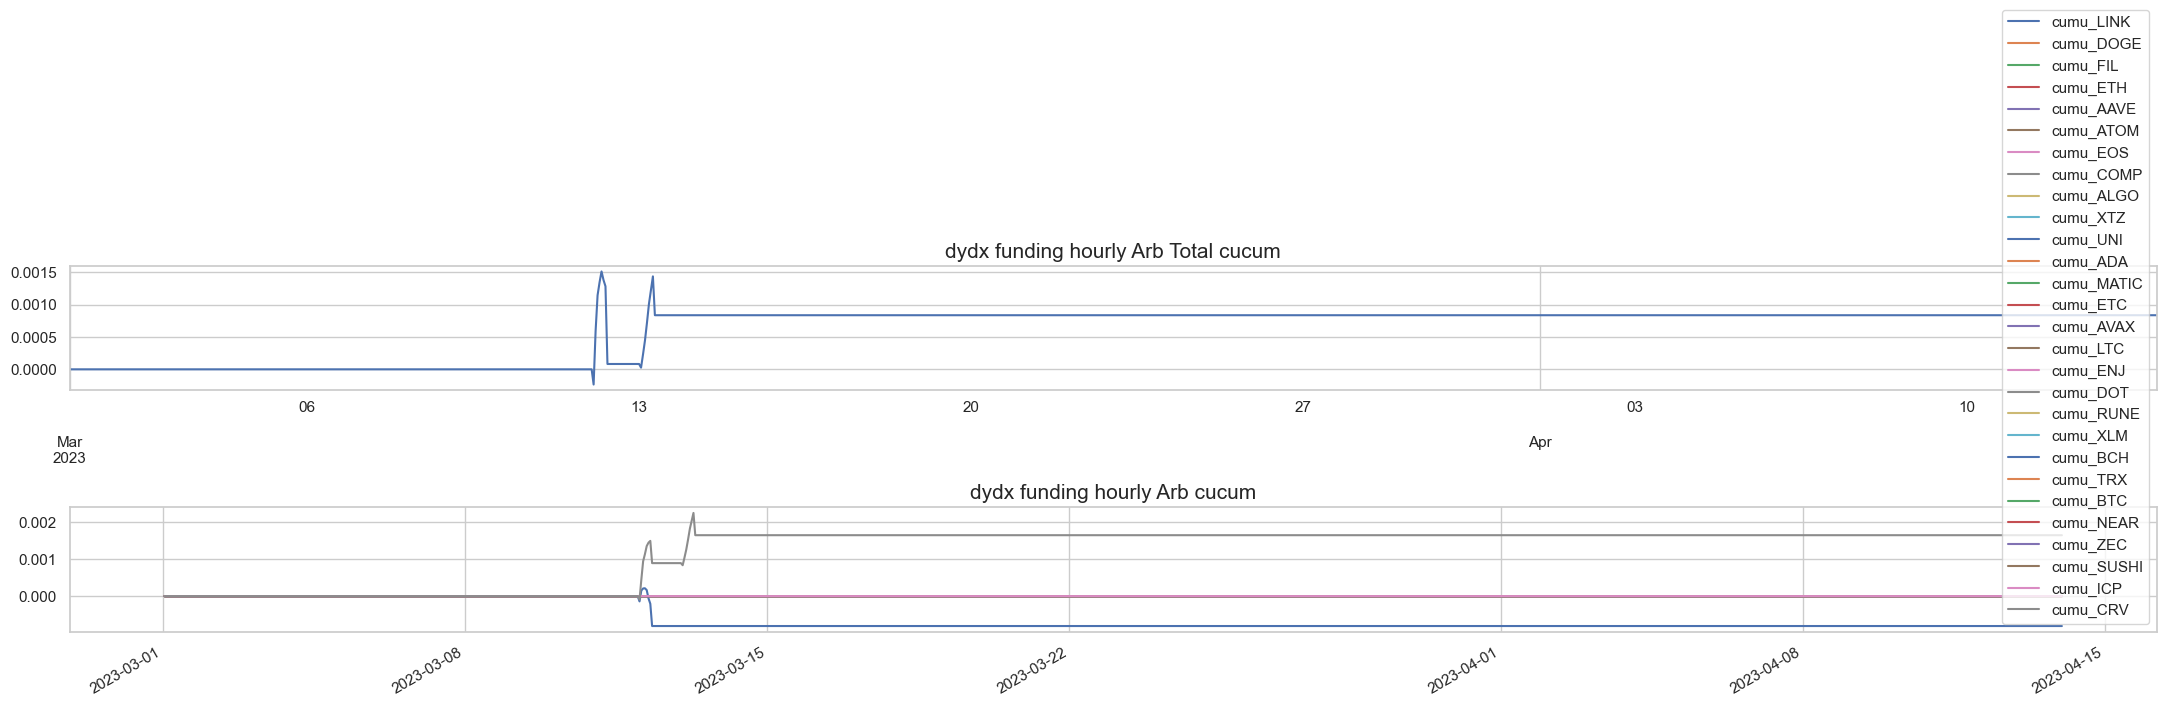

In [20]:
import seaborn as sns
sns.set_theme(style= "whitegrid" )
fig, ax = plt.subplots(nrows = 2, figsize=(22, 8))

bt_cumu_df.sum(axis=1).plot(ax=ax[0])
ax[0].set_title(f'dydx funding hourly Arb Total cucum',fontsize=15)
bt_cumu_df.plot(ax=ax[1])
ax[1].set_title(f'dydx funding hourly Arb cucum',fontsize=15)
plt.tight_layout()

### Parammeter tuning 

In [22]:
transaction_cost = 0.06*0.01 *2
opt_result = pd.DataFrame()

for holding_window in range(1, 8):
    bt_metric = pd.DataFrame()
    for funding_thresh in np.arange(0.01*0.01 /4, 0.06*0.01 * 2 /3 , 0.01*0.01 /4):

        funding_thresh = round(funding_thresh, 8)

        bt_metric['holding_window'] = [holding_window]
        bt_metric['funding_thresh'] = [funding_thresh]
    
        bt_cumu_df = pd.DataFrame() 
        n_trade = 0
       
        for symbol in COIN_LIST_TOTAL:

            data_symbol = get_data(symbol)
            df = data_symbol[data_symbol['dydx_rate'] == data_symbol['dydx_rate']]
            df = df.set_index('timestamp')

            bt_df = funding_hourly_arb(price=df['dydx_open'], hourly_funding=df['dydx_rate'], holding_window=holding_window, funding_thresh=funding_thresh, 
                                    price_name='dydx_open', factor_name='dydx_funding')
            bt = dydx_funding_hourly_arb_backtest(hourly_funding=bt_df['dydx_funding'], position=bt_df.pos, factor_name='dydx_funding', transaction_cost = transaction_cost)
            bt_cumu = bt.cumu.copy()
            bt_cumu.name = 'cumu_' + symbol
            bt_cumu_df = pd.concat([bt_cumu_df, bt_cumu], axis=1)
            n_trade = n_trade + bt.trade.sum()
        
        bt_metric['n_trade'] = [n_trade]
        bt_metric['total_cumu'] = [bt_cumu_df.sum(axis=1).iloc[-1]]
    
        opt_result = pd.concat([opt_result, bt_metric])

Text(0.5, 1.0, 'cumu_table of DYDX funding_hourly_arb')

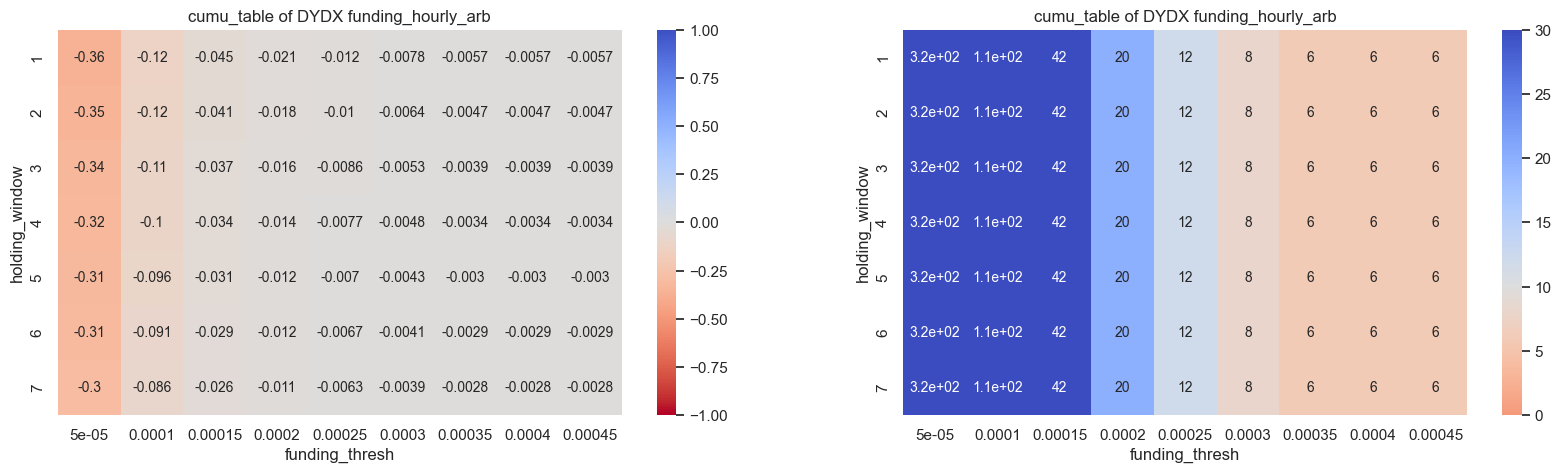

In [78]:
cumu_table = opt_result.pivot(index='holding_window', columns='funding_thresh', values='total_cumu')
n_trade_table = opt_result.pivot(index='holding_window', columns='funding_thresh', values='n_trade')

sns.set_theme(style= "whitegrid" )
fig, ax = plt.subplots(ncols=2, nrows= 1, figsize=(20, 5))
sns.heatmap( cumu_table , vmin= -1 , vmax=1, ax=ax[0], cmap="coolwarm_r", annot=True, center = 0.01, annot_kws={'size': 10} ) # annot=True,
ax[0].set_title(f'cumu_table of DYDX funding_hourly_arb', fontsize = 12)
sns.heatmap( n_trade_table , vmin= 0 , vmax= 30, ax=ax[1], cmap="coolwarm_r", annot=True, center = 10, annot_kws={'size': 10} ) # annot=True,
ax[1].set_title(f'cumu_table of DYDX funding_hourly_arb', fontsize = 12)

In [ ]:
# 9?b